In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

# Change working directory to project root
os.chdir('../../')

import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
import json
import imageio
from hmr4d.utils.wis3d_utils import make_wis3d, add_motion_as_lines
from hmr4d.dataset.rich.rich_utils import get_w2az_sahmr, parse_seqname_info
from hmr4d.utils.geo_transform import apply_T_on_points

In [24]:
all_dump = torch.load('dump.pt')
vid_to_indices = {}
for i, dump in enumerate(all_dump):
    vid = dump['meta'][0]
    if vid not in vid_to_indices:
        vid_to_indices[vid] = [i]
    else:
        vid_to_indices[vid].append(i)
print("Numver of clips:", len(all_dump))
print('Number of videos: ', len(vid_to_indices))
print(all_dump[0].keys())

indices = list(sorted(vid_to_indices.keys()))

Numver of clips: 996
Number of videos:  191
dict_keys(['meta', 'pred_ayfz_motion', 'pred_T_ayfz2c', 'gt_ayfz_motion', 'gt_T_ayfz2c', 'wham_ayfz_motion', 'wham_cr_motion'])


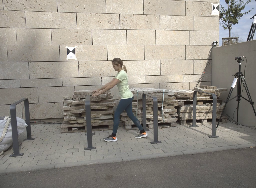

In [119]:
import decord
from PIL import Image

vseq_id = 146
dump_id = vid_to_indices[indices[vseq_id]][1]
dump = all_dump[dump_id]
vid, (start, end) = dump["meta"]

vr = decord.VideoReader(str(Path("inputs/RICH/hmr4d_support/video") / vid / "video.mp4"))
frames = vr.get_batch(list(range(start, end))).asnumpy()  # get start to end
Image.fromarray(frames[35][::4, ::4])

In [91]:
# dump_id = 1
L = 100
dump = all_dump[dump_id]
print(dump.keys())

wis3d = make_wis3d(name="pipeline")
# our_motion = dump['pred_ayfz_motion'][:L]  # (L, 22, 3)
# cr_motion = dump['gt_ayfz_motion'][:L]  # (L, 22, 3)
global_motion = dump['gt_ayfz_motion'][:L]  # (L, 22, 3)
add_motion_as_lines(global_motion, wis3d)

dict_keys(['meta', 'pred_ayfz_motion', 'pred_T_ayfz2c', 'gt_ayfz_motion', 'gt_T_ayfz2c', 'wham_ayfz_motion', 'wham_cr_motion'])


In [105]:
wis3d = make_wis3d(name="pipeline_pick")#, time_postfix=True)

select_frames = [16, 36, 83]
prior_motion_root = dump['gt_ayfz_motion'][16:, 0]  # (L, 3)
prior_motion = dump['gt_ayfz_motion'][select_frames]  # (L, 22, 3)

for i in range(prior_motion.shape[0]):
    wis3d.set_scene_id(0)
    add_motion_as_lines(prior_motion[[i]], wis3d, name=f'prior_{i}', const_color='grey')
wis3d.add_point_cloud(prior_motion_root, name='root-prior')

# Add cr
cr_motion = dump['wham_ayfz_motion'][select_frames]  # (L, 22, 3)
cr_motion = cr_motion - cr_motion[:, [0]]

for i in range(cr_motion.shape[0]):
    wis3d.set_scene_id(0)
    add_motion_as_lines(cr_motion[[i]] + torch.tensor([ 2.0,1.,0]), wis3d, name=f'cr_{i}', const_color='blue')

# Add obs3d_guidance
obs3d_guidance = cr_motion + prior_motion[:, [0]]
for i in range(obs3d_guidance.shape[0]):
    wis3d.set_scene_id(0)
    add_motion_as_lines(obs3d_guidance[[i]] + torch.tensor([ 4.0,0.,0]), wis3d, name=f'obs3d_guidance_{i}', const_color='green')
wis3d.add_point_cloud(prior_motion_root + torch.tensor([ 4.0,0.,0]), name='root-prior-obs')


In [121]:
output_to_save = {
    "prior_motion": prior_motion.numpy(),
    "cr_motion": cr_motion.numpy(),
    "obs3d_guidance": obs3d_guidance.numpy(),
    "prior_motion_root": prior_motion_root.numpy(),
}
np.save("obs3dguidance.npy", output_to_save)

In [95]:
cr_motion.shape

torch.Size([3, 22, 3])